In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
folder_path = "/kaggle/input/sih-final/multiclass"
all_loc = os.listdir(folder_path)
import tensorflow as tf
import tifffile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.utils import plot_model
from tensorflow import keras
import keras.metrics as tfm
import tifffile
import keras.backend as K
from keras import layers
from keras.constraints import  max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TensorBoard
from keras.activations import softmax
from keras.optimizers import Adam,SGD
from keras.metrics import MeanIoU,Precision,Recall,Accuracy
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.metrics as tfm
import keras.backend as K
from keras import layers
from keras.layers import LeakyReLU
from keras.constraints import  max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TensorBoard
from keras.activations import softmax
from keras.metrics import MeanIoU,Precision,Recall,Accuracy

from keras.losses import BinaryCrossentropy,CategoricalCrossentropy
import numpy as np
import pandas as pd
from glob import glob

# tf.config.threading.set_inter_op_parallelism_threads(4)
# tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.set_soft_device_placement(enabled=True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras import layers, models
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import pandas as pd
from glob import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np

def clip_outliers(arr, clip_value):
    """
    Clip outliers in a numpy array to a specified value.

    Parameters:
    - arr: Input numpy array.
    - clip_value: Value to which outliers will be clipped.

    Returns:
    - Numpy array with outliers clipped.
    """
    return np.clip(arr, a_min=None, a_max=clip_value)

# Example usage


In [2]:
snippet=256
bands=['B2','B3','B4','B8'] 
x_train=np.zeros(shape=(0,snippet,snippet,len(bands))) 
y_train=np.zeros(shape=(0,snippet,snippet))
def extract_snippets(image, snippet_size=(snippet, snippet)): 
    snippets = [] 
    height=image.shape[0] 
    width=image.shape[1]

    for i in range(0, height, snippet_size[0]):
        for j in range(0, width, snippet_size[1]):
            snippet = image[i:i+snippet_size[0], j:j+snippet_size[1],:]
            snippets.append(snippet)
    return snippets
def extract_snippets_label(image, snippet_size=(snippet, snippet)): 
    snippets = [] 
    height=image.shape[0] 
    width=image.shape[1] 
    for i in range(0, height, snippet_size[0]): 
        for j in range(0, width, snippet_size[1]): 
            snippet = image[i:i+snippet_size[0], j:j+snippet_size[1]] 
            snippets.append(snippet) 
    return snippets

all_loc=['loc1','loc2','loc3','loc4','loc5']

for fold in all_loc: 
    temp=folder_path+"/"+fold 
    tif_files = [file for file in os.listdir(temp) if file.endswith('.tif')] 
    im=np.array(Image.open(temp+"/"+tif_files[0])) 
    data=np.zeros((im.shape[0],im.shape[1],len(bands))) 
    i=0 
    for file_name in bands: 
        im = Image.open(temp+"/"+file_name+".tif") 
        imarray = np.array(im) 
        data[:,:,i]=imarray 
        i+=1 
        data=np.array(data)

    print(data.shape)
    lab = tifffile.imread(temp+"/labels/mask.tif")
#     data=data/np.max(data)
    label=np.array(lab)
    height=data.shape[0]
    width=data.shape[1]
    pad_height = (height // snippet + 1) * snippet - height
    pad_width = (width // snippet + 1) * snippet - width
    pad = np.pad(data, ((0, pad_height), (0, pad_width),(0,0)), mode='constant')
    labpad=np.pad(label, ((0, pad_height), (0, pad_width)), mode='constant')
    tmp1=np.array(extract_snippets(pad))
    tmp2=np.array(extract_snippets_label(labpad))
    x_train=np.concatenate((x_train,tmp1),axis=0)
    y_train=np.concatenate((y_train,tmp2),axis=0)
    print(y_train.shape)
# for i in range(len(bands)):
#     x_train[:,:,:,i]/=np.max(x_train[:,:,:,i])
print(x_train.shape) 


(4881, 3470, 4)
(280, 256, 256)
(2113, 8588, 4)
(586, 256, 256)
(2040, 3205, 4)
(690, 256, 256)
(3008, 2761, 4)
(822, 256, 256)
(5689, 9957, 4)
(1719, 256, 256)
(1719, 256, 256, 4)


In [3]:
y_train=y_train.astype(int)
num_classes = 7  # Number of classes (0 to 6)
y_one_hot = np.eye(num_classes)[y_train]

In [5]:
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 
from sklearn.metrics import confusion_matrix

epsilon = 1e-5
smooth = 1
def iou_metric(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(y_true * tf.round(y_pred), dtype=tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + tf.round(y_pred) > 0, dtype=tf.float32))
    iou = intersection / union
    return iou
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.6
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
# def dice_coef(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
def focal_loss(y_true, y_pred):
    alpha=0.5
    gamma=2
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Clip to avoid numerical instability
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_sum(alpha * tf.pow(1.0 - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1.0 - pt_0))
def mean_iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Optionally cast back to integer before confusion matrix if needed
    y_true_int = tf.cast(y_true, dtype=tf.int64)
    y_pred_int = tf.cast(y_pred, dtype=tf.int64)

    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    confusion_matrix = tf.math.confusion_matrix(y_true_int, y_pred_int, num_classes=5)
    sum_over_row = tf.reduce_sum(confusion_matrix, axis=0)
    sum_over_col = tf.reduce_sum(confusion_matrix, axis=1)
    true_positives = tf.linalg.diag_part(confusion_matrix)

    denominator = sum_over_row + sum_over_col - true_positives
    iou = tf.math.divide_no_nan(true_positives, denominator)
    mean_iou = tf.reduce_mean(iou)

    return mean_iou

    return mean_iou
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=151)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_categorical_focal_loss(y_true, y_pred, gamma=2.0, alpha=None, class_weights=None):
    """
    Weighted categorical focal loss for multiclass segmentation.

    Parameters:
    - y_true: Ground truth one-hot encoded labels (Tensor).
    - y_pred: Predicted probabilities (Tensor).
    - gamma: Focusing parameter. Default is 2.0.
    - alpha: Weight factor to balance positive and negative samples. Default is None.
    - class_weights: Weight factor for each class. Default is None.

    Returns:
    - Weighted categorical focal loss (Tensor).
    """
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Calculate focal loss
    focal_loss = -y_true * (1 - y_pred)**gamma * tf.math.log(y_pred)

    # Apply class weights if provided
    if class_weights is not None:
        focal_loss *= class_weights

    # Apply alpha if provided
    if alpha is not None:
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss *= alpha_factor

    return tf.reduce_sum(focal_loss, axis=-1)

# Example usage

# Create a simple model


# Compile the model using weighted focal loss
# model.compile(optimizer='adam',
#               loss=lambda y_true, y_pred: weighted_categorical_focal_loss(y_true, y_pred, class_weights=[1, 2, 1, 1, 1]))

# Train the model using your data
# model.fit(...)


In [6]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False,):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer='he_normal',
        #kernel_constraint=max_norm(3)
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])

    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size,bands, num_classes):
    model_input = keras.Input(shape=(image_size, image_size,bands))
    print(model_input)
    print(num_classes)
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    #x=Dropout(0.5)(x)
    x = convolution_block(x)
    #x=Dropout(0.5)(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(7,kernel_size=(1, 1), activation='softmax')(x)
    return keras.Model(inputs=model_input, outputs=model_output)






    #define Model
model = DeeplabV3Plus(image_size=snippet, bands=4, num_classes=7)
# model.summary()
#model.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-5),loss=focal_tversky_loss, metrics=[iou_coef,dice_coef,Precision(),Recall()])
model.compile(optimizer=SGD(learning_rate=0.01,momentum=0.9), loss=lambda y_true, y_pred: weighted_categorical_focal_loss(y_true, y_pred, class_weights=[2, 1, 4, 1, 0.5, 4, 3]),metrics=['accuracy'])

    #Save Model Structure
# json_file = model.to_json()
# with open(weight_json, 'w') as f:
#     f.write(json_file)

callbacks = [
    EarlyStopping(patience=35, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0000001, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint('best_weight.h5', verbose=1, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=False),
    
]

history = model.fit(x_train[:300],y_one_hot[:300], epochs=35, validation_split=0.2,callbacks=callbacks,shuffle=True)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
7
Epoch 1/35
8/8 [==============================] - ETA: 0s - loss: 1.7103 - accuracy: 0.4969
Epoch 1: val_accuracy improved from -inf to 0.57812, saving model to best_weight.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 60s 3s/step - loss: 1.7103 - accuracy: 0.4969 - val_loss: 7.9388 - val_accuracy: 0.5781 - lr: 0.0100
Epoch 2/35
8/8 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.6880
Epoch 2: val_accuracy did not improve from 0.57812
8/8 [==============================] - 6s 698ms/step - loss: 1.0109 - accuracy: 0.6880 - val_loss: 7.9388 - val_accuracy: 0.5781 - lr: 0.0100
Epoch 3/35
8/8 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.7648
Epoch 3: val_accuracy did not improve from 0.57812
8/8 [==============================] - 6s 703ms/step - loss: 0.7477 - accuracy: 0.7648 - val_loss: 7.9388 - val_accuracy: 0.5781 - lr: 0.0100
Epoch 4/35
8/8 [==============================] - ETA: 0s - loss: 0.8469 - accuracy: 0.7608
Epoch 4: val_accuracy did not improve from 0.57812
8/8 [==============================] - 6s 705ms/step - loss: 0.8469 - accuracy: 0.7608 - val_loss: 7.9388 - val_accuracy: 0.5781 - lr: 0.0100
Epoch

In [ ]:
classes=7
s = tf.keras.Input(shape=(snippet, snippet, len(bands)))
nb_filter = [32,64,128,256,512]
model = Sequential()

c1 = layers.Conv2D(32, (3, 3), activation='elu',  padding='same')(s)
c1 = layers.Dropout(0.5)(c1)
c1 = layers.Conv2D(32, (3,3), activation='elu', padding='same')(c1)
c1 = layers.Dropout(0.5)(c1)
p1 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c1)



c2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = layers.Dropout(0.5) (c2)
c2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = layers.Dropout(0.5) (c2)
p2 = layers.MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = layers.concatenate([up1_2, c1], name='merge12', axis=3)
c3 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = layers.Dropout(0.5) (c3)
c3 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = layers.Dropout(0.5) (c3)

conv3_1 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = layers.Dropout(0.5) (conv3_1)
conv3_1 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = layers.Dropout(0.5) (conv3_1)
pool3 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = layers.concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = layers.Dropout(0.5) (conv2_2)
conv2_2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = layers.Dropout(0.5) (conv2_2)

up1_3 = layers.Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = layers.concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = layers.Dropout(0.5) (conv1_3)
conv1_3 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = layers.Dropout(0.5) (conv1_3)

conv4_1 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = layers.Dropout(0.5) (conv4_1)
conv4_1 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = layers.Dropout(0.5) (conv4_1)
pool4 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = layers.Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = layers.concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = layers.Dropout(0.5) (conv3_2)
conv3_2 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = layers.Dropout(0.5) (conv3_2)

up2_3 = layers.Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = layers.concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = layers.Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(classes, (1, 1), activation='softmax', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)
# nestnet_output_4=Dense(classes,activation='softmax')(conv1_5)

model = models.Model(inputs=s, outputs=nestnet_output_4)
model.summary()

meanIoU = tf.keras.metrics.MeanIoU(num_classes=5)
learning_rate = 0.001  # You can replace this with your desired learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[mean_iou])
# model.compile(optimizer=optimizer, loss=focal_loss, metrics=['accuracy',iou_metric])


# Define callbacks
callbacks = [
    EarlyStopping(patience=35, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0000001, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint("best_weight.h5", verbose=1, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=False),
]

# Train the model
history = model.fit(x_train,y_one_hot,epochs=50, validation_split=0.2,callbacks=callbacks)
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 3, 3)
plt.plot(history.history['iou_metric'])
plt.plot(history.history['val_iou_metric'])
plt.title('Model iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
plt.show()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 256, 256, 32)         1184      ['input_4[0][0]']             
                                                                                                  
 dropout_60 (Dropout)        (None, 256, 256, 32)         0         ['conv2d_70[0][0]']           
                                                                                                  
 conv2d_71 (Conv2D)          (None, 256, 256, 32)         9248      ['dropout_60[0][0]']          
                                                                                            

In [57]:
import numpy as np
# from scio
# Assuming x_train is a NumPy array with shape (num_samples, 128, 128, 6)
# Assuming y_train is a NumPy array with shape (num_samples, 128, 128)

# Function to rotate 3D images and labels
def rotate_3D_images_and_labels(images, labels, angles=[90, 180, 270]):
    rotated_images = []
    rotated_labels = []

    for angle in angles:
        for image, label in zip(images, labels):
            rotated_image = np.stack([np.rot90(channel, k=angle // 90) for channel in np.moveaxis(image, -1, 0)], axis=-1)
            rotated_label = np.rot90(label, k=angle // 90)

            rotated_images.append(rotated_image)
            rotated_labels.append(rotated_label)

    return np.array(rotated_images), np.array(rotated_labels)

# Rotate 3D images and labels
x_train, y_train = rotate_3D_images_and_labels(x_train, y_train)



In [21]:
x_train.shape,y_train.shape

((690, 256, 256, 4), (690, 256, 256))

In [30]:

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
num_classes=6
def conv_block(x, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = L.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = L.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

#     b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(p3, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """ # Change this to the actual number of classes

    outputs = L.Conv2D(7, 1, padding="same", activation="softmax")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

if __name__ == "__main__":
    input_shape = (snippet, snippet,len(bands))
    model = attention_unet(input_shape)
    model.summary()


Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 4)]          0         []                            
                                                                                                  
 conv2d_145 (Conv2D)         (None, 64, 64, 64)           2368      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_126 (B  (None, 64, 64, 64)           256       ['conv2d_145[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_126 (Activation  (None, 64, 64, 64)           0         ['batch_normaliza

In [ ]:
y_train=y_train.astype(int)
num_classes = 7  # Number of classes (0 to 6)
y_one_hot = np.eye(num_classes)[y_train]

In [ ]:
y_one_hot.shape


In [28]:
from keras import backend as K
# def dice_coefficient(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred)
#     union = K.sum(y_true) + K.sum(y_pred)
#     return (2.0 * intersection) / (union + 1e-8)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coefficient(y_true, y_pred)
# from keras import backend as K

def dice_coefficient_multi_class(y_true, y_pred, num_classes):
    dice_coefficients = []

    for class_idx in range(num_classes):
        # Binary masks for the current class
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]

        # Calculate Dice coefficient for the current class
        intersection = K.sum(y_true_class * y_pred_class)
        union = K.sum(y_true_class) + K.sum(y_pred_class)
        dice_coefficient_class = (2.0 * intersection) / (union + 1e-8)

        # Append to the list of Dice coefficients for each class
        dice_coefficients.append(dice_coefficient_class)

    # Average Dice coefficient over all classes
    average_dice_coefficient = K.mean(K.stack(dice_coefficients))

    return average_dice_coefficient

# def dice_loss(y_true, y_pred):
#     numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
#     denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
#     dice_coefficient = tf.reduce_mean(numerator / denominator)
#     loss = 1 - dice_coefficient
#     return loss

def calculate_jaccard_index(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))

    jaccard_index = intersection / union if union > 0 else 0.0
    return jaccard_index


def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


def focal_loss(y_true, y_pred):
    alpha=0.5
    gamma=2
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Clip to avoid numerical instability
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_sum(alpha * tf.pow(1.0 - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1.0 - pt_0))


input_shape=(snippet,snippet,len(bands))
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=35, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0000001, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint("best_weight.h5", verbose=1, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=False),
]
model = attention_unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train,y_one_hot,epochs=35,validation_split=0.2 , callbacks=callbacks, shuffle=True)

Epoch 1/35


ResourceExhaustedError: Graph execution error:

Detected at node 'Attention-UNET/up_sampling2d_11/resize/ResizeBilinear' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_42/2958913030.py", line 69, in <module>
      model.fit(x_train,y_one_hot,epochs=35,validation_split=0.2 , callbacks=callbacks, shuffle=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/up_sampling2d.py", line 132, in call
      return backend.resize_images(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend.py", line 3703, in resize_images
      x = tf.image.resize(x, new_shape, method=interpolations[interpolation])
Node: 'Attention-UNET/up_sampling2d_11/resize/ResizeBilinear'
OOM when allocating tensor with shape[32,256,256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Attention-UNET/up_sampling2d_11/resize/ResizeBilinear}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_50435]

In [12]:
predictions=model.predict(x_train)
predictions=np.argmax(predictions,axis=-1)
plt.imshow(y_train[0])
plt.show()
plt.imshow(predictions[0])

18/18 [==============================] - 2s 140ms/step


In [13]:
predictions=np.argmax(predictions,axis=-1)

In [14]:
predictions.shape

(561, 128, 128)

In [15]:
predictions[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4]])

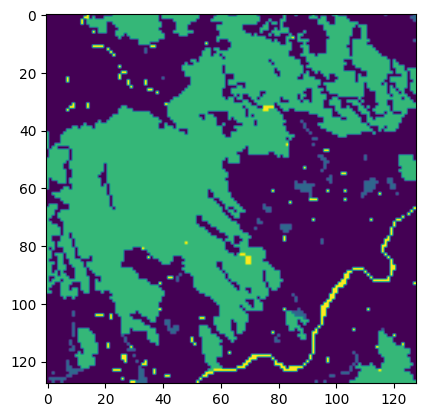

In [16]:
plt.imshow(y_train[0])

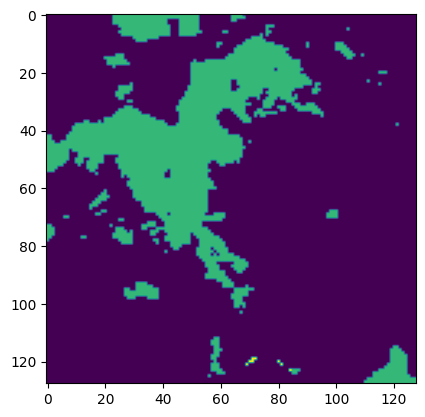

In [18]:
plt.imshow(predictions[0], cmap='viridis')

In [15]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Change the output layer for multi-class classification
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

if __name__ == "__main__":
    input_shape = (128, 128, len(bands))
    num_classes = 7  # Change this to the actual number of classes
    model = build_unet(input_shape, num_classes)
    model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 64)         2368      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 128, 128, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 128, 128, 64)         0         ['batch_normalization_18[0

In [16]:
from keras import backend as K
# def dice_coefficient(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred)
#     union = K.sum(y_true) + K.sum(y_pred)
#     return (2.0 * intersection) / (union + 1e-8)

# def dice_loss(y_true, y_pred):
#     return 1.0 - dice_coefficient(y_true, y_pred)
# from keras import backend as K

def dice_coefficient_multi_class(y_true, y_pred, num_classes):
    dice_coefficients = []

    for class_idx in range(num_classes):
        # Binary masks for the current class
        y_true_class = y_true[..., class_idx]
        y_pred_class = y_pred[..., class_idx]

        # Calculate Dice coefficient for the current class
        intersection = K.sum(y_true_class * y_pred_class)
        union = K.sum(y_true_class) + K.sum(y_pred_class)
        dice_coefficient_class = (2.0 * intersection) / (union + 1e-8)

        # Append to the list of Dice coefficients for each class
        dice_coefficients.append(dice_coefficient_class)

    # Average Dice coefficient over all classes
    average_dice_coefficient = K.mean(K.stack(dice_coefficients))

    return average_dice_coefficient

# def dice_loss(y_true, y_pred):
#     numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
#     denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
#     dice_coefficient = tf.reduce_mean(numerator / denominator)
#     loss = 1 - dice_coefficient
#     return loss

def calculate_jaccard_index(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))

    jaccard_index = intersection / union if union > 0 else 0.0
    return jaccard_index


def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


def focal_loss(y_true, y_pred):
    alpha=0.5
    gamma=2
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Clip to avoid numerical instability
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_sum(alpha * tf.pow(1.0 - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1.0 - pt_0))

num_classes=7
input_shape=(128,128,len(bands))
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=35, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0000001, monitor='val_loss', mode='min', verbose=1),
    ModelCheckpoint("best_weight.h5", verbose=1, monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=False),
]
model = build_unet(input_shape,num_classes)
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])
model.fit(x_train,y_one_hot,epochs=30,validation_split=0.2 , callbacks=callbacks, shuffle=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.7437
Epoch 1: val_accuracy improved from -inf to 0.03461, saving model to best_weight.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 85s 683ms/step - loss: 0.1192 - accuracy: 0.7437 - val_loss: 3.7258 - val_accuracy: 0.0346 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.7852
Epoch 2: val_accuracy improved from 0.03461 to 0.15304, saving model to best_weight.h5
67/67 [==============================] - 32s 475ms/step - loss: 0.0794 - accuracy: 0.7852 - val_loss: 0.6310 - val_accuracy: 0.1530 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.7920
Epoch 3: val_accuracy improved from 0.15304 to 0.57443, saving model to best_weight.h5
67/67 [==============================] - 32s 475ms/step - loss: 0.0719 - accuracy: 0.7920 - val_loss: 0.2111 - val_accuracy: 0.5744 - lr: 0.0010
Epoch 4/30
67/67 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.7954
Epoch 4: val_accuracy did not improve from 0.57443
67/67 [==============================] - 31s 459ms/step - 

In [19]:
ans=model.predict(x_train)
ans=np.argmax(ans,axis=-1)
plt.imshow(y_train[0])
plt.show()
plt.imshow(ans[0])

17/17 [==============================] - 2s 133ms/step


IndexError: index 0 is out of bounds for axis 0 with size 0

['B2.tif', 'B3.tif', 'B4.tif', 'B8.tif']
(2113, 8588, 4)
(1156, 128, 128, 4)
37/37 [==============================] - 4s 81ms/step


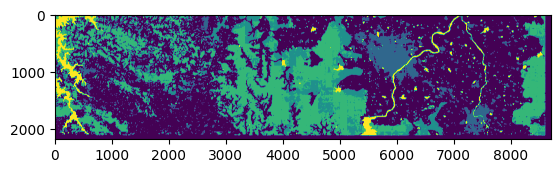

In [8]:
from keras.models import model_from_json

# Load the model architecture from JSON
with open('/kaggle/input/modellll/model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
bands=[ 'B2.tif', 'B3.tif', 'B4.tif', 'B8.tif']
model = model_from_json(loaded_model_json)

# Load the weights into the model
model.load_weights('/kaggle/input/modellll/best_weight.h5')
snippet=128
folder_path = "/kaggle/input/sih-final/multiclass"
all_loc = os.listdir(folder_path)
x_train=np.zeros(shape=(0,snippet,snippet,4))
y_train=np.zeros(shape=(0,snippet,snippet))
# settlements={'loc1':3,'loc2':9}
def extract_snippets(image, snippet_size=(snippet, snippet)):
    snippets = []
    height=image.shape[0]
    width=image.shape[1]
    
    for i in range(0, height, snippet_size[0]):
        for j in range(0, width, snippet_size[1]):
            snippet = image[i:i+snippet_size[0], j:j+snippet_size[1],:]
            snippets.append(snippet)
    return snippets
fold='loc2'
temp=folder_path+"/"+fold
tif_files = [file for file in os.listdir(temp) if file.endswith('.tif')]
tif_files=[ 'B2.tif', 'B3.tif', 'B4.tif', 'B8.tif']
print(tif_files)
im=np.array(Image.open(temp+"/"+tif_files[0]))
data=np.zeros((im.shape[0],im.shape[1],len(bands)))
i=0
for file_name in tif_files:
    im = Image.open(temp+"/"+file_name)
    imarray = np.array(im)
    data[:,:,i]=imarray
    i+=1
data=np.array(data)
# data=data/np.max(data)
print(data.shape)
# lab = Image.open(temp+"/labels/label.tif")
# label=np.array(lab)
# label[label != settlements[fold]] = 0
# label[label == settlements[fold]] = 1
height=data.shape[0]
width=data.shape[1]
pad_height = (height // snippet + 1) * snippet - height
pad_width = (width // snippet + 1) * snippet - width
pad = np.pad(data, ((0, pad_height), (0, pad_width),(0,0)), mode='constant')
# labpad=np.pad(label, ((0, pad_height), (0, pad_width)), mode='constant')
tmp1=np.array(extract_snippets(pad))
# tmp2=np.array(extract_snippets_label(labpad))
x_train=np.concatenate((x_train,tmp1),axis=0)
# y_train=np.concatenate((y_train,tmp2),axis=0)
print(x_train.shape)
# x_train/=np.mean(x_train)
# x_train*=1000
# for i in range(len(bands)):
#     x_train[:,:,:,i]/=np.max(x_train[:,:,:,i])
ans=model.predict(x_train)
ans=np.argmax(ans,axis=-1)
ans=ans.reshape(-1,128,128)
output=np.zeros(shape=(pad.shape[0],pad.shape[1]))
ans.shape
height,width=pad.shape[0:2]
k=height//128
l=width//128
for i in range(0, height, 128):
    for j in range(0, width, 128):
        output[i:i+128, j:j+128]=ans[(i*l)//(128)+(j//128)]
# result = (output > 0.9).astype(int)
plt.imshow(output)

In [9]:
import tifffile
# output=np.round(output)
img = Image.fromarray(output)


# Save the image as a TIFF file
tifffile.imsave("outputnew.tif", output)

/tmp/ipykernel_43/1460073618.py:7: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("outputnew.tif", output)


In [8]:
from IPython.display import FileLink

# File path
file_path = '/kaggle/working/best_weight.h5'

# Create a download link
download_link = FileLink(r'best_weight.h5')

# Display the link
download_link

/kaggle/working/best_weight.h5

In [44]:
print(output)

[[ 28. 107.  87. ...  32.   5.  70.]
 [ 28. 107.  87. ...  32.   5.  70.]
 [ 28. 107.  87. ...  32.   5.  70.]
 ...
 [  4.  93.  35. ...  81.  62.  77.]
 [  4.  93.  35. ...  81.  62.  77.]
 [  4.  93.  35. ...  81.  62.  77.]]


In [7]:
# img = tifffile.imread(result)

# Save the image as a TIFF file
tifffile.imsave("output1.tif", output)

/tmp/ipykernel_3299/2900324738.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("output1.tif", output)


In [16]:
print(before)
before.shape,after.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [2. 2. 0. ... 0. 0. 0.]
 ...
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]]


((823, 1620), (640, 640))

In [8]:
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

























